# Scaling hidden state estimation to multiple samples

This notebook extends the probabilistic hidden state estimation problem with a linear generating function to the case of multiple input samples.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

from scipy.stats import norm
from types import SimpleNamespace

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_environment

mpl.style.use("seaborn-deep")

We will use the same assumptions as the previous examples:
* $x^*$: The true **external state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the external states of the generative process ($x^*$) denote the size of a food source and the outcomes ($y$) are represents levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. This is represented by the variable ($x$), the **hidden state** which captures the agent's belief about the food size that could have generated the observed sensory data. We use the following agent and environment:

$$
    \mathscr{E} \triangleq 
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* x^* & \text{Generating function} \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

$$
    \mathcal{M} \triangleq 
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y_i \mid x) = \mathcal{N}(y_i; g_{\mathcal{M}}, \sigma^2_y) & \text{Likelihood} \\
        p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; m_x, s^2_x) & \text{Prior on } x \\
        g_{\mathcal{M}}(x, \theta) = \beta_0 + \beta_1 x & \text{Generating function} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Linear parameters} \\ 
        \phi := \left \{\sigma^2_y = 0.25, s^2_x = 0.25, m_x = 4 \right \} & \text{Other parameters}
    \end{cases}
$$

The only difference is that observation are now indexed by $i = 0, \dots, N$ to indicate multiple samples are generated from the same hidden state. We use the linear environment we have used previously and generate $N=30$ samples with $x^*=2$.

In [2]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 0.25  # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)

# Generate data for three different x_star values
x_range = np.linspace(start=0.01, stop=5, num=500)   # Range of x_star
x_star  = 2                                          # External state
N       = 30                                         # Number of samples
y       = np.zeros(N)                                # Empty array for N=30 samples

# Generate
for i in range(N):
    y[i] = env.generate(x_star)

# The `norm()` function will not work unless we reshape `y` and add an extra dimension making it of size `[30, 1]`. The operation below adds this extra dimension. This is effectively like passing in 30 individual samples in one array instead of an array of 30 samples.

y = np.expand_dims(y, axis=1)

We desire an agent performs the same hidden state estimation (with a linear generating function) as before but we will extend it to multiple samples. The trick to doing this entirely lies in how we construct the likelihood,

$$
    p(y^{(0)}, \dots, y^{(N)} \mid x) = \prod_{i=0}^N p(y^{(i)} \mid x)
$$

This equation tells that that probability over *all* samples given a hidden state is equal to the product of the likelihoods for *each* sample given the hidden state. Let's examine the likelihood function in code to see how this works.

In [3]:
def generating_function(beta_0: float, beta_1: float, x: float) -> float:
    return beta_1 * x + beta_0

x_range = np.linspace(start=0.01, stop=5, num=500)
mu_y    = generating_function(beta_0=3, beta_1=2, x=x_range)

likelihood_i = norm.pdf(y, loc=mu_y, scale=0.5)

In [4]:
print(f"The shape of the likelihood is [{likelihood_i.shape[0]} x {likelihood_i.shape[1]}]")

The shape of the likelihood is [30 x 500]


This makes sense - the likelihood has 30 rows, one for each sample, and 500 columns, one for each point in our 500-point grid over $x$. What the `scipy` function has done is calculate a likelihood for each of the 30 samples in question. Each sample has an associated likelihood with 500 elements in it, one for each element in the grid over the range of $x$. Then each of these likelihoods are treated as stacked rows to make a matrix.

We could for example write the equivalent statement and confirm that the result is the same:

In [5]:
grid_size  = x_range.shape[0]
likelihood_i = np.zeros([N, grid_size])

for i in range(N):
    likelihood_i[i] = norm.pdf(y[i], loc=mu_y, scale=0.5)
    
print(f"The shape of the likelihood is [{likelihood_i.shape[0]} x {likelihood_i.shape[1]}]")

The shape of the likelihood is [30 x 500]


What we have here is a matrix of likelihoods for *each* sample. In other words,

$$
    p(y^{(0)}, \dots, y^{(N)} \mid x) = \prod_{i=0}^N \begin{bmatrix} p(y^{(0)} \mid x) \\ \vdots \\ p(y^{(N)} \mid x) \end{bmatrix}
$$


If we want to compute the likelihood over *all* samples what we should do is take the product *down* the rows of the likelihood matrix. We can do this by using `prod(axis=0)` on the array. This produces:

In [6]:
likelihood = likelihood_i.prod(axis=0)
print(f"The shape of the likelihood over all samples is {likelihood.shape[0]}.")

The shape of the likelihood over all samples is 500.


Now we have just 500 elements which reflects the likelihood over all samples. 

Note that usually we will work in log space because logarithms are more numerically stable and they change multiplication into addition which is generally easier to work with. With this mind, we can define the **log-likelihood** as the log of the likelihood:

$$
    \log p(y^{(0)}, \dots, y^{(N)} \mid x) = \sum_{i=0}^N \log p(y^{(i)} \mid x)
$$

Note that we are taking the *sum* because taking a logarithm transforms a product into a sum. In code we write this as follows:

In [7]:
likelihood_i = norm.pdf(y, loc=mu_y, scale=0.5)
log_likelihood_i = np.log(likelihood_i)
log_likelihood = log_likelihood_i.sum(axis=0)

We also define a log prior which we can add it to the log-likelihood over samples to obtain the log generative model. This is once again because instead of multiplying the likelihood and prior we add the log likelihood and log prior:

$$
\log p(y^{(i)}, x) = \sum_{i=1}^n \log p(y^{(i)} \mid x) + \log p(x)
$$

In [8]:
prior = norm.pdf(x_range, loc=4, scale=0.5)
log_prior = np.log(prior)
gen_model = log_likelihood + log_prior

As we know, we can invert this generative model with Bayes' theorem to obtain the posterior by dividing by the model evidence. To full code for model inversion is shown below.

**Note**: We could do the above process without log space. However, most operations in this book will operate in log space so we will begin the tradition of (almost) always using the log likelihood and log prior going forward.

In [9]:
class ExactLinearAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        # Model components
        self.log_likelihood = None
        self.log_prior = None
        self.gen_model = None
        self.evidence = None
        self.posterior = None
        
    def gm(self, x: float) -> float:
        return self.params.beta_1 * x + self.params.beta_0  
        
    def generative_model(self, y: float, generating_function: callable):
        likelihood_i    = norm.pdf(y, loc=generating_function, scale=self.params.std_y)
        self.prior      = norm.pdf(self.params.x_range, loc=self.params.m_x, scale=self.params.s_x)
        
        self.log_likelihood = np.log(likelihood_i).sum(axis=0)
        self.log_prior = np.log(self.prior)
        
        return self.log_likelihood + self.log_prior
        
    def infer_state(self, y: float):
        
        generating_function = self.gm(x=self.params.x_range) 
        self.log_gen_model = self.generative_model(y, generating_function)
        
        # Use the log-sum-exp trick to normalize by the evidence
        self.posterior = np.exp(self.log_gen_model - np.max(self.log_gen_model))  

In [10]:
# Agent parameters
agent_params = {
    "beta_0" : 3,     # Linear parameter intercept
    "beta_1" : 2,     # Linear parameter slope
    "std_y"  : 0.25,  # Likelihood standard deviation
    "m_x"    : 4,     # Prior mean
    "s_x"    : 0.25,  # Prior standard deviation
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

agent = ExactLinearAgent(params=agent_params)
agent.infer_state(y)

posterior = agent.posterior
likelihood = np.exp(agent.log_likelihood)
prior = np.exp(agent.log_prior)

<Figure size 432x288 with 0 Axes>

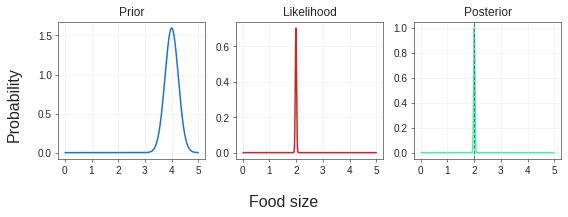

In [11]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range, prior, c="#1874cd")        # Prior
axes[1].plot(x_range, likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range, posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].axvline(x=(np.argmax(posterior) + 1) / 100, linestyle="dashed", linewidth=1)

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [13]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the expected or inferred food size, the hidden state estimate with 30 observations (samples) from the generative process in the true state {x_star}.')

The posterior mode is 2.01. This is the expected or inferred food size, the hidden state estimate with 30 observations (samples) from the generative process in the true state 2.


You will note that the prediction is must better than the case with one sample and the effect of the prior is swamped out. As we receive more and more data, posterior can be updated and become a better and better approximation of the true state as the variance shrinks.